### Import the necessary libraries





In [ ]:
import re
import nltk
import torch
import string
import unicodedata
import contractions
import pandas as pd
import torch.nn as nn
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf
import missingno as msno
import torch.optim as optim
import matplotlib.pyplot as plt






from wordcloud import WordCloud
from unidecode import unidecode
from collections import Counter
from nltk.corpus import stopwords
from torch.nn import functional as F
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from transformers import EarlyStoppingCallback
from tensorflow.keras.models import Sequential
from torch.utils.data import DataLoader, Dataset
from sklearn.neighbors import KNeighborsClassifier
from transformers import Trainer, TrainingArguments
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from transformers.trainer_utils import EvalPrediction
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional



nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('all')

In [ ]:
!jupyter nbconvert --to html --output=Detect_AI_text.html '/content/drive/MyDrive/Personal Projects/Detect ai text using LLMs/Detect_AI_text.ipynb'


[NbConvertApp] Converting notebook /content/drive/MyDrive/Personal Projects/Detect ai text using LLMs/Detect_AI_text.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.11/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.11/dist-packages/nbconvert/nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.export_single_noteboo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the Dataset


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Personal Projects/Detect ai text using LLMs/Dataset/Training_Essay_Data.csv')
df.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


### Analyzing the missing values


<Axes: >

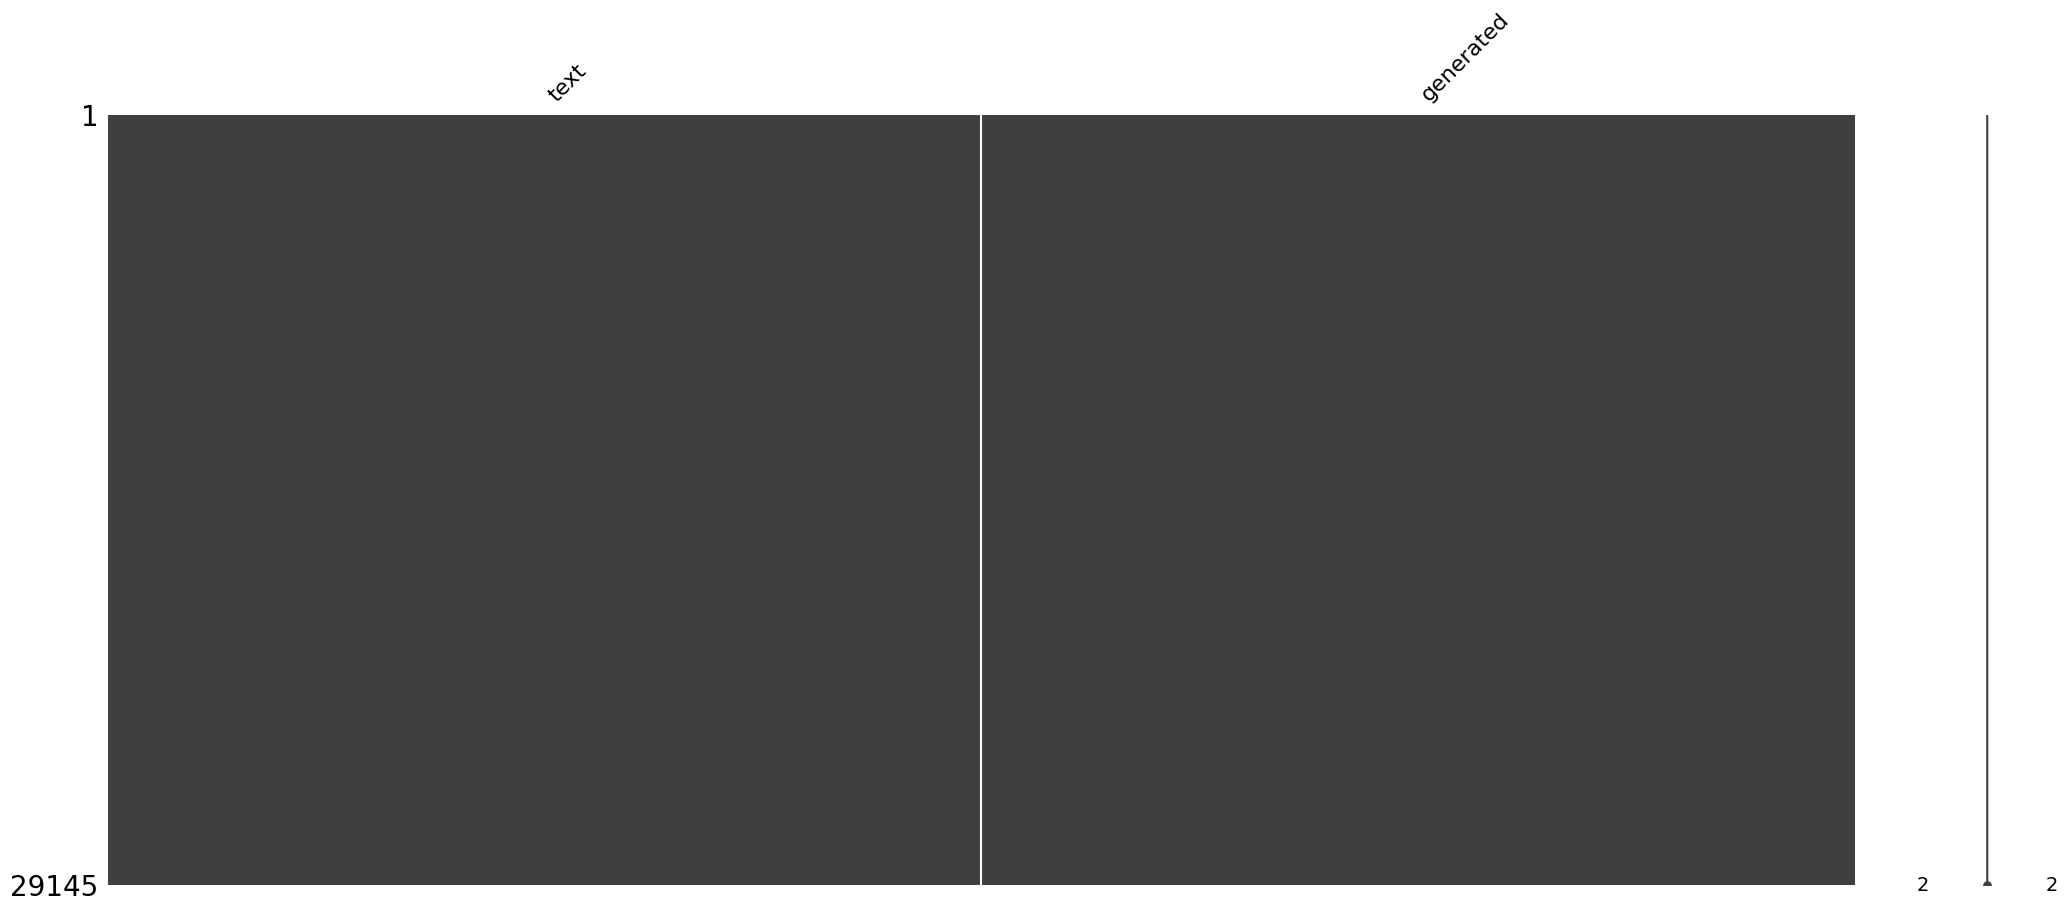

In [ ]:
msno.matrix(df)

### Dataset Characterstics


Dataset size


In [ ]:
df.shape

(29145, 2)

Checking for Duplicates


In [ ]:
print('Duplicate Rows: ', len(df[df.duplicated()]))

Duplicate Rows:  1805


In [ ]:
df.drop_duplicates(inplace=True)
df.shape

(27340, 2)

Check for data types


In [ ]:
df.dtypes

text         object
generated     int64
dtype: object

Summary of Dataframe


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27340 entries, 0 to 27766
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27340 non-null  object
 1   generated  27340 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 640.8+ KB


Class Distribution


In [ ]:
class_counts = df['generated'].value_counts()
class_counts

generated
0    16122
1    11218
Name: count, dtype: int64

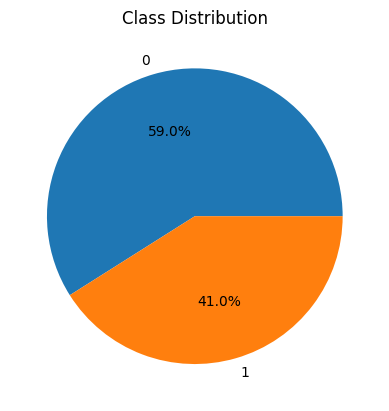

In [ ]:
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

#### Initial Analysis of dataset

<ul>
    <li>Dataset initially had 29145 rows.</li>
    <li>There are only two columns in the dataset: text column has the essay text and generated column has the label (0 - Human Written Essay , 1 - AI Generated Essay).</li>
    <li>The dataset had no missing values.</li>
    <li>1805 rows with duplicate values were dropped.</li>
    <li>Almost 60% of the rows are human generated and 40% rows are AI generated.</li>
</ul>


### EDA

In [ ]:
df['word_count'] = df['text'].apply(lambda text: len(re.split(r'\s+|[' + re.escape(string.punctuation) + r']+', text)) - 1)
df['sentence_count'] = df['text'].apply(lambda text: len(nltk.sent_tokenize(text)))
df['essay_length'] = df['text'].apply(lambda text: len(text))
df['punctuation_count'] = df['text'].apply(lambda text: sum(1 for char in text if char in string.punctuation))
df['unique words ratio'] = df['text'].apply(lambda text: len(set(text.split()))/len(text.split()))
df.head()

,text,generated,word_count,sentence_count,essay_length,punctuation_count,unique words ratio
0,Car-free cities have become a subject of incre...,1,664,28,4091,90,0.573913
1,"Car Free Cities Car-free cities, a concept ga...",1,608,26,3757,96,0.623782
2,A Sustainable Urban Future Car-free cities ...,1,604,27,3828,92,0.580078
3,Pioneering Sustainable Urban Living In an e...,1,602,23,3739,83,0.585742
4,The Path to Sustainable Urban Living In an ...,1,597,22,3698,86,0.579256


In [ ]:
def plot_histogram(df, column, label_name):
    """
    Plots a histogram of sentence count color-coded by the 'generated' class.

    Parameters:
        df (pd.DataFrame): DataFrame with 'sentence_count' and 'generated' columns.
    """
    # Set style
    sns.set_style("whitegrid")

    # Create histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column, hue='generated', bins='auto', kde=True,
                 palette={0: 'blue', 1: 'red'}, alpha=0.6)

    # Labels & Title
    plt.xlabel(f"{label_name}", fontsize=12)
    plt.ylabel("# of essays", fontsize=12)
    plt.title(f"Distribution of {label_name} by Class", fontsize=14)
    plt.legend(labels=["Human (0)", "AI (1)"])

    # Show plot
    plt.show()

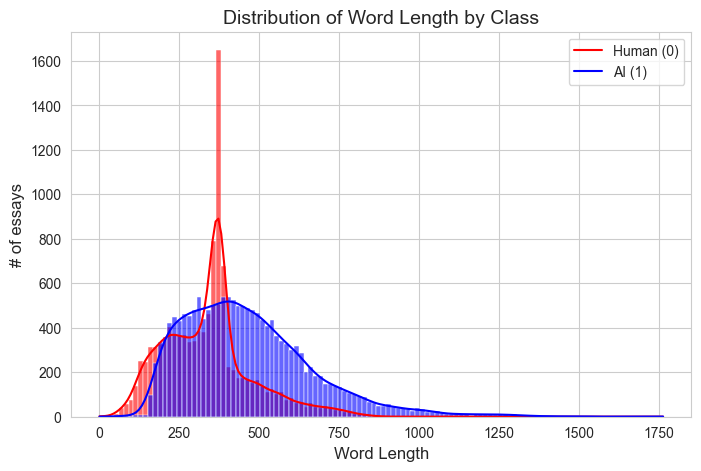

In [ ]:
plot_histogram(df, 'word_count', 'Word Length')

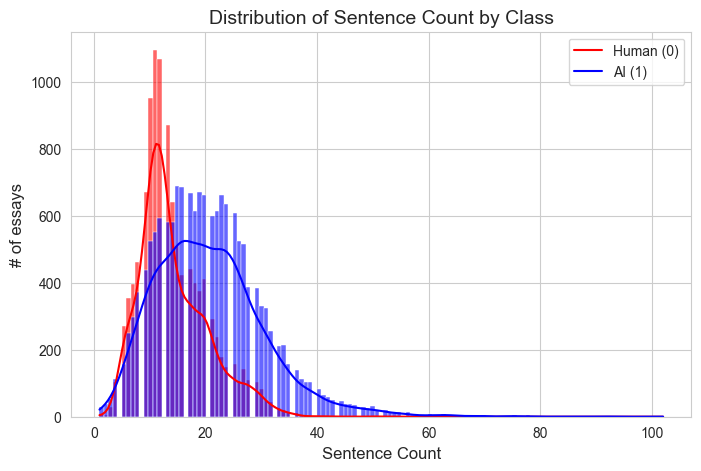

In [ ]:
plot_histogram(df, 'sentence_count', 'Sentence Count')

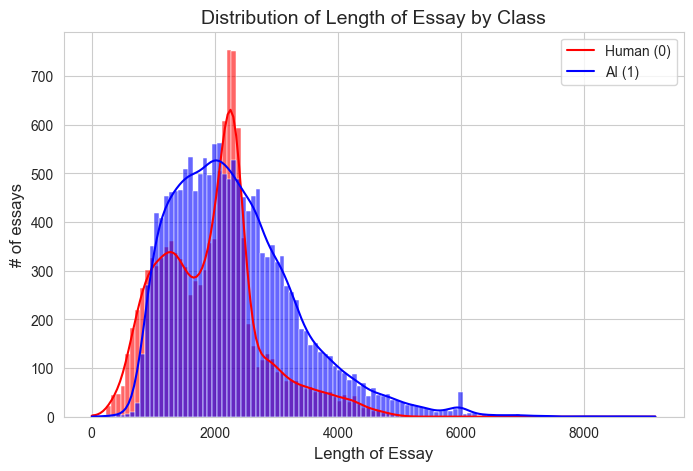

In [ ]:
plot_histogram(df, 'essay_length', 'Length of Essay')

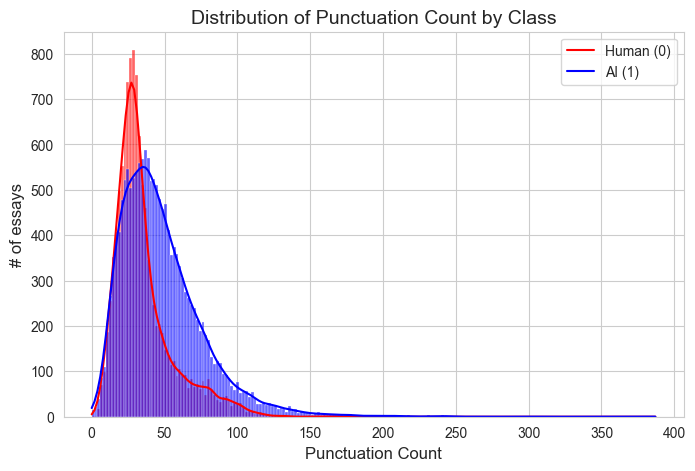

In [ ]:
plot_histogram(df, 'punctuation_count', 'Punctuation Count')

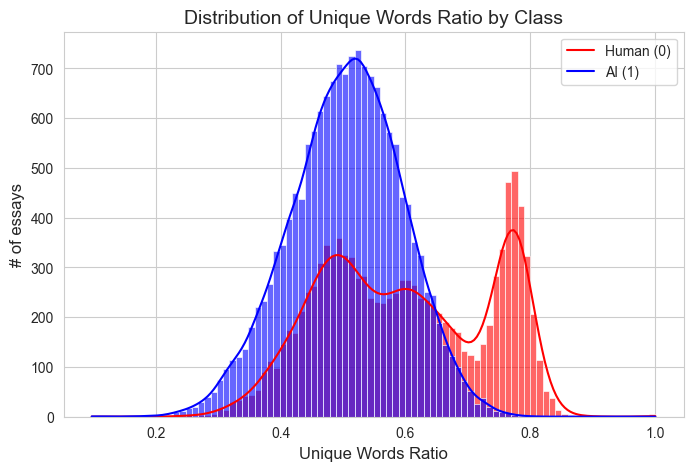

In [ ]:
plot_histogram(df, 'unique words ratio', 'Unique Words Ratio')

C:\Users\anshu\AppData\Local\Temp\ipykernel_21932\1555881443.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


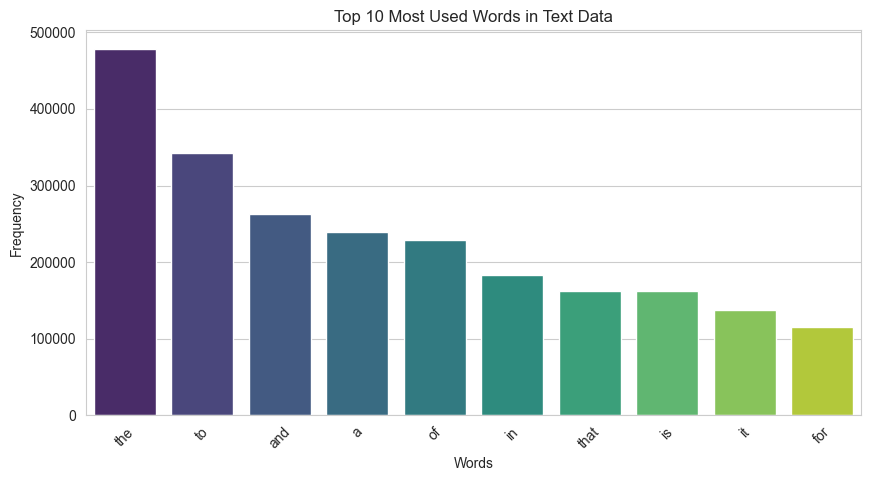

In [ ]:
all_text = " ".join(df['text'])
words = re.findall(r'\b\w+\b', all_text.lower())
word_counts = Counter(words)

top_10_words = word_counts.most_common(10)

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(counts), palette='viridis')

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 10 Most Used Words in Text Data")
plt.xticks(rotation=45)
plt.show()

Most of the words are Stopwords. So, now I would be preprocessing to remove the stopwords and observe the visualization.

### Data preprocessing

In [ ]:
def preprocess_text(text):
    text = unicodedata.normalize("NFKC", text)  # Normalize Unicode
    text = unidecode(text)  # Convert accented characters
    text = contractions.fix(text)  # Expand contractions
    text = text.lower().strip()  # Lowercasing & remove leading/trailing spaces
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text)  # Collapse multiple spaces into one

    tokens = nltk.word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Stopword removal
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization

    return " ".join(tokens)

In [ ]:
df = df[['text', 'generated']]
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

Now i will check for some prior visualizations to analyze the preprocessed data.

In [ ]:
train_df['word_count'] = train_df['text'].apply(lambda text: len(re.split(r'\s+|[' + re.escape(string.punctuation) + r']+', text)) - 1)
train_df['essay_length'] = train_df['text'].apply(lambda text: len(text))
train_df['unique words ratio'] = train_df['text'].apply(lambda text: len(set(text.split()))/len(text.split()))
train_df.head()

,text,generated,word_count,essay_length,unique words ratio
3541,Cells Phones have an affect on everyone's life...,0,354,1840,0.418239
8212,The Facial Action Coding System (FACS) technol...,0,397,2258,0.470914
9315,The Facual Coding System enabling identificati...,0,290,1619,0.509653
16260,Explain how small acts of kindness can have a ...,0,521,2620,0.427419
19989,\nOutdoor activities are essential for our wel...,1,270,1442,0.618257


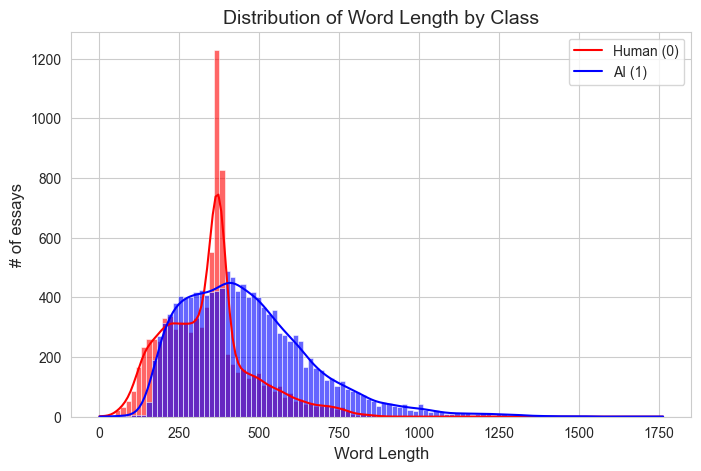

In [ ]:
plot_histogram(train_df, 'word_count', 'Word Length')

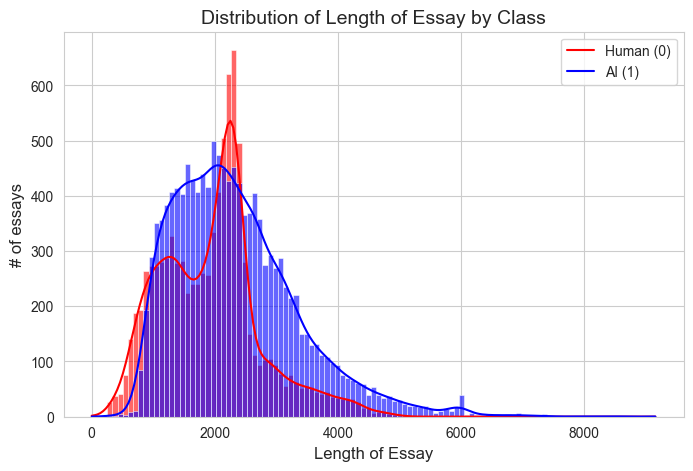

In [ ]:
plot_histogram(train_df, 'essay_length', 'Length of Essay')

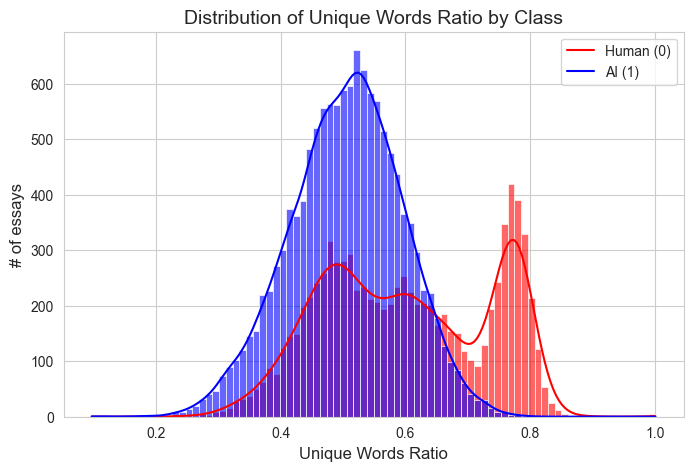

In [ ]:
plot_histogram(train_df, 'unique words ratio', 'Unique Words Ratio')

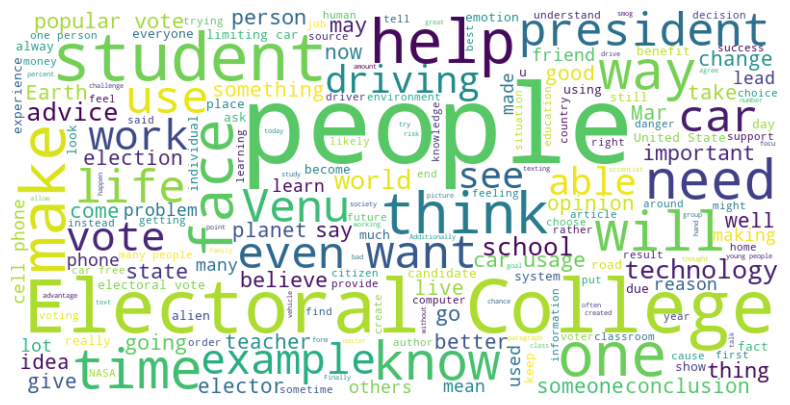

In [ ]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

text_data = " ".join(train_df['text'].dropna())
generate_wordcloud(text_data)

In [ ]:
train_df = train_df[['text', 'generated']]

#### Analysis of Feature Engineering

Based on the above, plots, there isn't a significant distinction of both classes. So, I will use only the given features.


### Modelling

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)

# Fit on train data and transform both train and validation data
X_train = vectorizer.fit_transform(train_df['text']).toarray()
X_val = vectorizer.transform(val_df['text']).toarray()

# Step 2: Extract target labels
y_train = train_df['generated']  # Assuming 'generated' is the target column
y_val = val_df['generated']  # Target for validation data

# Step 3: Convert data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Step 4: Define XGBoost parameters with GPU acceleration
params = {
    'objective': 'binary:logistic',  # Binary classification (0 or 1)
    'eval_metric': 'logloss',  # Log loss for binary classification
    'tree_method': 'gpu_hist',  # Use GPU for training
    'predictor': 'gpu_predictor',  # Use GPU for prediction
    'verbosity': 1  # Show training progress
}

# Step 5: Train the model
model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'Validation')], early_stopping_rounds=10)

# Step 6: Make predictions
y_pred = model.predict(dval)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred]  # Convert probabilities to 0 or 1

# Step 7: Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:17:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:17:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	Validation-logloss:0.50249
[1]	Validation-logloss:0.40076
[2]	Validation-logloss:0.33226
[3]	Validation-logloss:0.28532
[4]	Validation-logloss:0.24365
[5]	Validation-logloss:0.21205
[6]	Validation-logloss:0.18653
[7]	Validation-logloss:0.16731
[8]	Validation-logloss:0.15159
[9]	Validation-logloss:0.13706
[10]	Validation-logloss:0.12613
[11]	Validation-logloss:0.11772
[12]	Validation-logloss:0.10770
[13]	Validation-logloss:0.09947
[14]	Validation-logloss:0.09418
[15]	Validation-logloss:0.08791
[16]	Validation-logloss:0.08423
[17]	Validation-logloss:0.08024
[18]	Validation-logloss:0.07718
[19]	Validation-logloss:0.07341
[20]	Validation-logloss:0.06996
[21]	Validation-logloss:0.06695
[22]	Validation-logloss:0.06469
[23]	Validation-logloss:0.06186
[24]	Validation-logloss:0.05949
[25]	Validation-logloss:0.05764
[26]	Validation-logloss:0.05616
[27]	Validation-logloss:0.05534
[28]	Validation-logloss:0.05384
[29]	Validation-logloss:0.05245
[30]	Validation-logloss:0.05046
[31]	Validation-lo

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:17:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3539
           1       0.99      0.99      0.99      2290

    accuracy                           0.99      5829
   macro avg       0.99      0.99      0.99      5829
weighted avg       0.99      0.99      0.99      5829

Confusion Matrix:


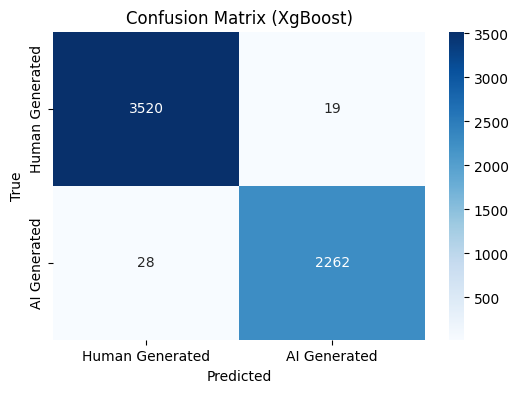

In [ ]:
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_val, y_pred)

# Visualize Confusion Matrix using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human Generated', 'AI Generated'], yticklabels=['Human Generated', 'AI Generated'])
plt.title("Confusion Matrix (XgBoost)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3539
           1       0.99      0.98      0.99      2290

    accuracy                           0.99      5829
   macro avg       0.99      0.99      0.99      5829
weighted avg       0.99      0.99      0.99      5829

Validation Accuracy: 0.9902


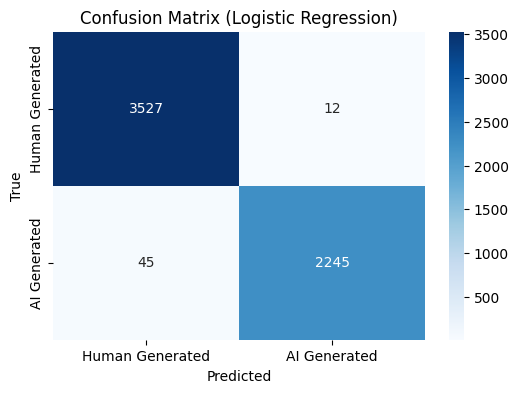

In [ ]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_val)

# Evaluate the model
print("Classification Report (Logistic Regression):")
print(classification_report(y_val, y_pred_lr))

accuracy = accuracy_score(y_val, y_pred_lr)
print(f"Validation Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix_lr = confusion_matrix(y_val, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Human Generated', 'AI Generated'], yticklabels=['Human Generated', 'AI Generated'])
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3223
           1       0.97      0.95      0.96      2245

    accuracy                           0.97      5468
   macro avg       0.97      0.97      0.97      5468
weighted avg       0.97      0.97      0.97      5468

Validation Accuracy: 0.9687


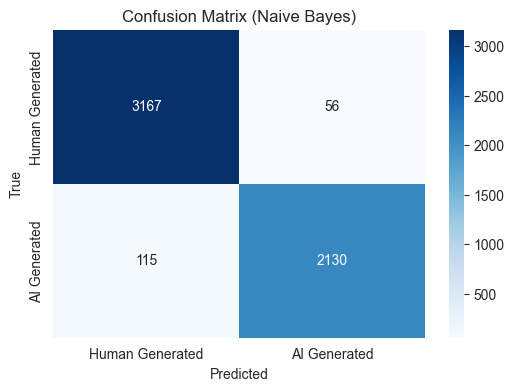

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred_nb = nb_model.predict(X_val)

# Evaluate the model
print("Classification Report (Naive Bayes):")
print(classification_report(y_val, y_pred_nb))

accuracy = accuracy_score(y_val, y_pred_nb)
print(f"Validation Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix_nb = confusion_matrix(y_val, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Human Generated', 'AI Generated'], yticklabels=['Human Generated', 'AI Generated'])
plt.title("Confusion Matrix (Naive Bayes)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3223
           1       0.98      0.96      0.97      2245

    accuracy                           0.97      5468
   macro avg       0.98      0.97      0.97      5468
weighted avg       0.97      0.97      0.97      5468

Validation Accuracy: 0.9748


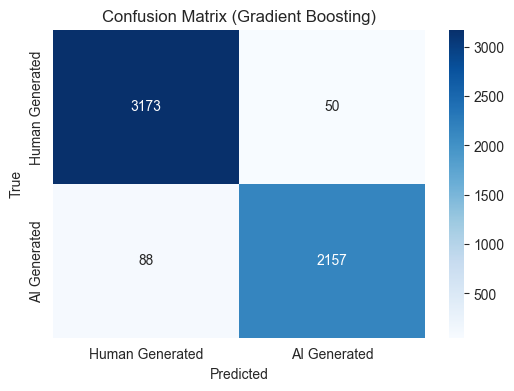

In [ ]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_val)

# Evaluate the model
print("Classification Report (Gradient Boosting):")
print(classification_report(y_val, y_pred_gb))

accuracy = accuracy_score(y_val, y_pred_gb)
print(f"Validation Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix_gb = confusion_matrix(y_val, y_pred_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', xticklabels=['Human Generated', 'AI Generated'], yticklabels=['Human Generated', 'AI Generated'])
plt.title("Confusion Matrix (Gradient Boosting)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3223
           1       0.98      0.95      0.97      2245

    accuracy                           0.97      5468
   macro avg       0.97      0.97      0.97      5468
weighted avg       0.97      0.97      0.97      5468

Validation Accuracy: 0.9720


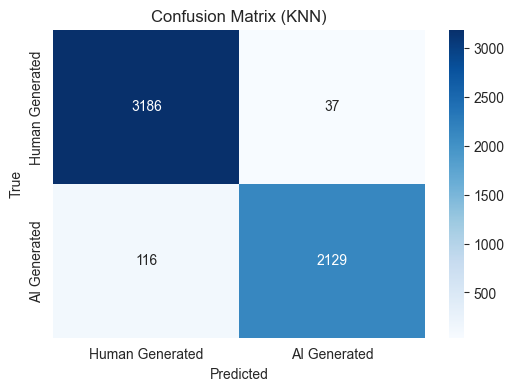

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predictions
y_pred_knn = knn_model.predict(X_val)

# Evaluate the model
print("Classification Report (KNN):")
print(classification_report(y_val, y_pred_knn))

accuracy = accuracy_score(y_val, y_pred_knn)
print(f"Validation Accuracy: {accuracy:.4f}")


# Confusion Matrix
conf_matrix_knn = confusion_matrix(y_val, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Human Generated', 'AI Generated'], yticklabels=['Human Generated', 'AI Generated'])
plt.title("Confusion Matrix (KNN)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Classification Report (LightGBM):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3223
           1       0.99      0.98      0.99      2245

    accuracy                           0.99      5468
   macro avg       0.99      0.99      0.99      5468
weighted avg       0.99      0.99      0.99      5468

Validation Accuracy: 0.9885


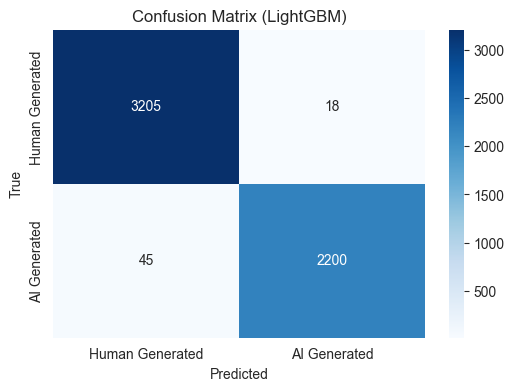

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Define model parameters
params = {
    'objective': 'binary',       # Binary classification
    'metric': 'binary_error',    # Performance metric
    'boosting_type': 'gbdt',     # Gradient Boosting Decision Tree
    'num_leaves': 31,            # Number of leaves in one tree
    'learning_rate': 0.05,       # Step size shrinkage
    'feature_fraction': 0.9,     # Use 90% of features
    'bagging_fraction': 0.8,     # Use 80% of data (bagging)
    'bagging_freq': 5,           # Perform bagging every 5 iterations
    'verbose': -1,
    'device': 'gpu'              # Use GPU if available
}

# Train the LightGBM model
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, val_data], num_boost_round=200)

# Predictions
y_pred_lgb = (lgb_model.predict(X_val) > 0.5).astype(int)

# Evaluate the model
print("Classification Report (LightGBM):")
print(classification_report(y_val, y_pred_lgb))

accuracy = accuracy_score(y_val, y_pred_lgb)
print(f"Validation Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix_lgb = confusion_matrix(y_val, y_pred_lgb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Human Generated', 'AI Generated'], yticklabels=['Human Generated', 'AI Generated'])
plt.title("Confusion Matrix (LightGBM)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Tokenize text
max_words = 10000  # Vocabulary size
max_length = 300   # Sequence length
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_val_seq = tokenizer.texts_to_sequences(val_df['text'])

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# Encode labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(train_df['generated'])
y_val_encoded = encoder.transform(val_df['generated'])

d:\Personal Projects\Detect AI text\Detect-AI-Text-using-LLMs\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 197s 551ms/step - accuracy: 0.7564 - loss: 0.4977 - val_accuracy: 0.6737 - val_loss: 0.5097
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 189s 552ms/step - accuracy: 0.9838 - loss: 0.0490 - val_accuracy: 0.9890 - val_loss: 0.0367
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 184s 538ms/step - accuracy: 0.9919 - loss: 0.0217 - val_accuracy: 0.9879 - val_loss: 0.0468
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 184s 539ms/step - accuracy: 0.9938 - loss: 0.0191 - val_accuracy: 0.9916 - val_loss: 0.0337
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 187s 548ms/step - accuracy: 0.9967 - loss: 0.0093 - val_accuracy: 0.9901 - val_loss: 0.0317
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 185s 540ms/step - accuracy: 0.9964 - loss: 0.0114 - val_accuracy: 0.9903 - val_loss: 0.0322
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 186s 544ms/step - accuracy: 0.9963 - loss: 0.0107 - val_accuracy: 0.9905 - val_loss: 0.0463
Epoch 8/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 223s 651ms/step - accuracy: 

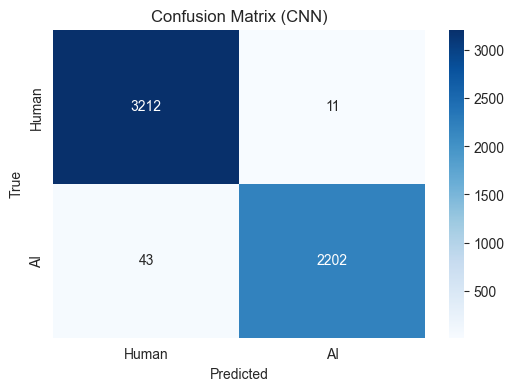

In [ ]:


# Build the Enhanced CNN Model
cnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=256, input_length=max_length),  # Larger embedding layer

    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(filters=64, kernel_size=7, activation='relu', padding='same'),
    GlobalMaxPooling1D(),

    Dense(256, activation='relu'),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model for 100 epochs
cnn_model.fit(X_train_padded, y_train_encoded,
              epochs=100,
              validation_data=(X_val_padded, y_val_encoded),
              batch_size=64,
              callbacks=[early_stopping])  # Early stopping added

# Predict
y_pred_cnn = (cnn_model.predict(X_val_padded) > 0.5).astype(int)

# Evaluate
print("Classification Report (CNN):")
print(classification_report(y_val_encoded, y_pred_cnn))

accuracy = accuracy_score(y_val, y_pred_cnn)
print(f"Validation Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix_cnn = confusion_matrix(y_val_encoded, y_pred_cnn)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.title("Confusion Matrix (CNN)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Epoch 1/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 2525s 7s/step - accuracy: 0.8582 - loss: 0.3167 - val_accuracy: 0.9261 - val_loss: 0.1848
Epoch 2/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 2076s 6s/step - accuracy: 0.9767 - loss: 0.0809 - val_accuracy: 0.9854 - val_loss: 0.0452
Epoch 3/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 2197s 6s/step - accuracy: 0.9858 - loss: 0.0459 - val_accuracy: 0.9911 - val_loss: 0.0307
Epoch 4/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 692s 2s/step - accuracy: 0.9895 - loss: 0.0326 - val_accuracy: 0.9928 - val_loss: 0.0225
Epoch 5/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1392s 4s/step - accuracy: 0.9928 - loss: 0.0218 - val_accuracy: 0.9911 - val_loss: 0.0289
Epoch 6/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1895s 5s/step - accuracy: 0.9961 - loss: 0.0144 - val_accuracy: 0.9925 - val_loss: 0.0262
Epoch 7/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1904s 5s/step - accuracy: 0.9946 - loss: 0.0184 - val_accuracy: 0.9916 - val_loss: 0.0268
Epoch 8/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1897s 5s/step - accuracy: 0.9945 - loss: 0.

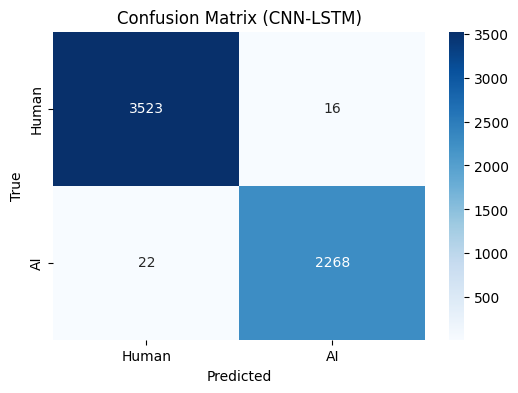

In [ ]:
# Build the CNN-LSTM Model
cnn_lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=256, input_length=max_length),  # Larger embedding layer

    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(filters=64, kernel_size=7, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=True)),  # LSTM added
    Dropout(0.4),

    Bidirectional(LSTM(64)),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
cnn_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model for 100 epochs
cnn_lstm_model.fit(X_train_padded, y_train_encoded,
                    epochs=100,
                    validation_data=(X_val_padded, y_val_encoded),
                    batch_size=64,
                    callbacks=[early_stopping])  # Early stopping added

# Predict
y_pred_cnn_lstm = (cnn_lstm_model.predict(X_val_padded) > 0.5).astype(int)

# Evaluate
print("Classification Report (CNN-LSTM):")
print(classification_report(y_val_encoded, y_pred_cnn_lstm))

accuracy = accuracy_score(y_val_encoded, y_pred_cnn_lstm)
print(f"Validation Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix_cnn_lstm = confusion_matrix(y_val_encoded, y_pred_cnn_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_cnn_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.title("Confusion Matrix (CNN-LSTM)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

# Splitting dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), df["generated"].tolist(), test_size=0.2, random_state=42
)

class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = [tokenize_function(text) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = {key: val.squeeze(0) for key, val in self.encodings[idx].items()}
        encoding["labels"] = self.labels[idx]
        return encoding

# Creating PyTorch dataset
train_dataset = CustomDataset(train_texts, train_labels)
val_dataset = CustomDataset(val_texts, val_labels)

# Creating DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Load the model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Set the device (GPU or CPU)
device = torch.device("cuda")
model.to(device)

# Set up optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save the model at the end of each epoch
    num_train_epochs=15,  # Train for 15 epochs
    per_device_train_batch_size=64,  # Training batch size
    per_device_eval_batch_size=64,  # Evaluation batch size
    logging_dir="./logs",  # Log directory
    logging_steps=10,  # Log every 10 steps
    save_total_limit=2,  # Keep only the last two saved models
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Use validation loss as the metric
    greater_is_better=False,  # Lower loss is better
    weight_decay=0.01,  # Apply weight decay
    push_to_hub=False,  # Prevent unnecessary hub uploads
)

# Early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

# Function to compute accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    predictions = logits.argmax(axis=1)  # Convert logits to predicted class
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # Fix function format
    callbacks=[early_stopping_callback],  # Add early stopping callback
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()

print(f"Validation Loss: {eval_results['eval_loss']}")
print(f"Validation Accuracy: {eval_results['eval_accuracy']}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-5c1b7912567c>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anshumohanty2002 (anshumohanty2002-university-of-southern-california) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.018200,0.009422,0.996912
2,0.013000,0.009254,0.997770
3,0.001400,0.054197,0.984217
4,0.000100,0.008048,0.998284
5,0.000000,0.010099,0.997598
6,0.000000,0.005594,0.998284
7,0.000000,0.008659,0.998456
8,0.000000,0.007718,0.998799
9,0.000000,0.007908,0.998799


Validation Loss: 0.005593555513769388
Validation Accuracy: 0.9982844398696175


In [ ]:
model.save_pretrained("/content/drive/MyDrive/Personal Projects/Detect ai text using LLMs/saved_model")
tokenizer.save_pretrained("/content/drive/MyDrive/Personal Projects/Detect ai text using LLMs/saved_model")

('/content/drive/MyDrive/Personal Projects/Detect ai text using LLMs/saved_model/tokenizer_config.json',
 '/content/drive/MyDrive/Personal Projects/Detect ai text using LLMs/saved_model/special_tokens_map.json',
 '/content/drive/MyDrive/Personal Projects/Detect ai text using LLMs/saved_model/vocab.txt',
 '/content/drive/MyDrive/Personal Projects/Detect ai text using LLMs/saved_model/added_tokens.json')


📊 Validation Accuracy per Epoch:
Epoch 1: Accuracy = 0.9969, Loss = 0.0094
Epoch 2: Accuracy = 0.9978, Loss = 0.0093
Epoch 3: Accuracy = 0.9842, Loss = 0.0542
Epoch 4: Accuracy = 0.9983, Loss = 0.0080
Epoch 5: Accuracy = 0.9976, Loss = 0.0101
Epoch 6: Accuracy = 0.9983, Loss = 0.0056
Epoch 7: Accuracy = 0.9985, Loss = 0.0087
Epoch 8: Accuracy = 0.9988, Loss = 0.0077
Epoch 9: Accuracy = 0.9988, Loss = 0.0079
Epoch 9: Accuracy = 0.9983, Loss = 0.0056


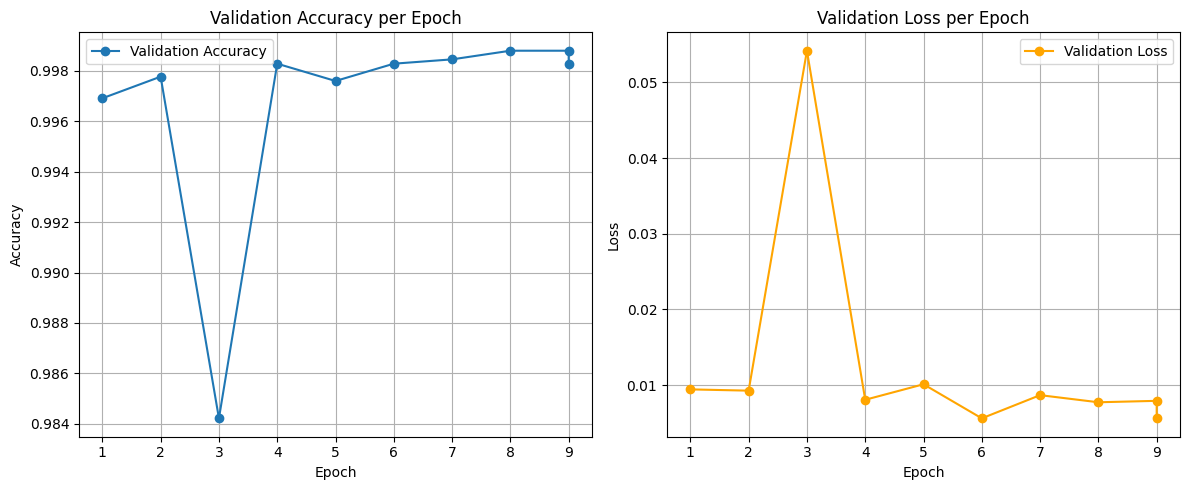


📝 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3539
           1       1.00      1.00      1.00      2290

    accuracy                           1.00      5829
   macro avg       1.00      1.00      1.00      5829
weighted avg       1.00      1.00      1.00      5829



In [ ]:
print("\n📊 Validation Accuracy per Epoch:")
epochs, val_acc, val_loss = [], [], []
for log in trainer.state.log_history:
    if "eval_accuracy" in log:
        epoch = log.get("epoch")
        acc = log["eval_accuracy"]
        loss = log["eval_loss"]
        print(f"Epoch {int(epoch)}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")
        epochs.append(epoch)
        val_acc.append(acc)
        val_loss.append(loss)

# Plotting validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss, marker='o', label='Validation Loss', color='orange')
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on validation set & classification report
model.eval()
all_preds, all_labels = [], []
for batch in val_dataloader:
    inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, axis=1).cpu().numpy()
    labels = batch["labels"].numpy()
    all_preds.extend(preds)
    all_labels.extend(labels)

print("\n📝 Classification Report:")
print(classification_report(all_labels, all_preds))


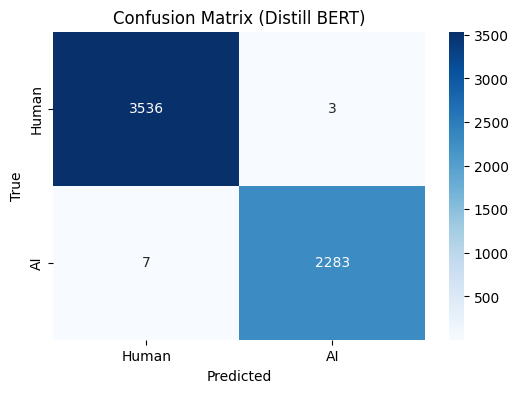

In [ ]:
conf_matrix_bert = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_bert, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.title("Confusion Matrix (Distill BERT)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Conclusion

DistilBert outperformed all the other model and achieved an accuracy of 99.82%.

